In [75]:
from IPython.display import SVG
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import re
from sknetwork.ranking import PageRank
from sknetwork.visualization import svg_graph

In [2]:
names=['en', 'hu', 'la', 'pl', 'id', 'uro', 'pos', 'defi', 'comment']
fl = pd.read_csv('4lang', sep='\t', names=names)

# Computing the definition graph

In [3]:
fl = fl[~fl.defi.isna()]

In [4]:
fl.en = fl.en.str.lower()

In [5]:
fl.defi = fl.defi.str.lower()

In [6]:
fl['ambig'] = fl.en.duplicated(keep=False)

In [7]:
unambig_set = set(fl.loc[~fl.ambig,'en'])

In [8]:
def unambig_hwd(record):
    return f'{record.en}/{record.id}' if record.ambig else record.en

In [9]:
fl['unambig_hwd'] = fl.apply(unambig_hwd, axis=1)

In [10]:
def drop_needless_disambig(term):
    if '/' in term:
        word, number = term.split('/')
        if word in unambig_set:
            return word
    return term

In [11]:
concept_chars = '=@a-zA-Z_/0-9-'
parens_and_stuff = "[]<>,()'"

def get_def_graph_outlist(record):
    hwd = f'{record.en}/{record.id}' if record.ambig else record.en
    return hwd, [drop_needless_disambig(concept) 
                 for concept in re.findall(f'[{concept_chars}]+', str(record.defi))]

In [12]:
def_graph = nx.DiGraph(dict(fl.apply(get_def_graph_outlist, axis=1).values))

# Exploration

In [189]:
#SVG(svg_graph(nx.adjacency_matrix(def_graph)))

In [52]:
pd.Series(dict(def_graph.in_degree())).sort_values(ascending=False)

has           555
=agt          357
=pat          323
at            308
cause         308
             ... 
proclaim        0
procession      0
drip            0
proceed         0
-able           0
Length: 3185, dtype: int64

In [53]:
pd.Series(dict(def_graph.out_degree())).sort_values(ascending=False)

park         16
lens         16
golf         15
fox          14
honey        14
             ..
@hamburg      0
@hanukkah     0
@hawaii       0
@himalaya     0
=for          0
Length: 3185, dtype: int64

In [13]:
fl.shape

(2965, 11)

In [14]:
def_graph.number_of_nodes()

3185

# Primitives

In [16]:
%pprint
print(sorted(set(concept 
                 for concept in set(def_graph.nodes) - set(fl.unambig_hwd)  if not re.match('^[=@]', concept))))
%pprint

Pretty printing has been turned OFF
['all', 'also', 'be', 'before', 'celebrate', 'characteristic', 'enthusiastic', 'er', 'for', 'for/2782', 'from', 'has', 'identity', 'inherent', 'is_a', 'lack', 'next_to', 'not', 'other', 'palm', 'part_of', 'passionate', 'target', 'tired', 'want']
Pretty printing has been turned ON


# Strongly connected components

In [107]:
def get_components_with_size():
    for component in nx.strongly_connected_components(def_graph):
        yield ', '.join(sorted(component)), len(component)

In [108]:
components = pd.Series(dict(get_components_with_size()))

In [122]:
len(components)

2478

In [145]:
components[0]

623

In [129]:
components[components>3][1:]

april, august, december, february, january, july, june, march/1563, may/1560, november, october, september    12
friday, monday, saturday, sunday, thursday, tuesday, wednesday                                                 7
bed, chair, cupboard, furniture, table                                                                         5
cereal, flour, grain, wheat                                                                                    4
draw/2707, pen, pencil, write                                                                                  4
king, monarch, queen, royal                                                                                    4
autumn, spring/2318, summer, winter                                                                            4
dtype: int64

In [130]:
components[components==3]

buttocks, seat, sit           3
camera, lens, photograph      3
calm, disturb, upset          3
answer, question, reply       3
bake, bread, cake             3
female, male, sex             3
justice, right/1191, wrong    3
actor, stage/2220, theatre    3
many, much, quantity          3
husband, marriage, wife       3
poem, poet, poetry            3
cutlery, fork, spoon          3
dtype: int64

In [140]:
components[components==2]

president, republic       2
bell, ring/2735           2
bottle, glass             2
dirt, dust                2
hill, mountain            2
hang, swing               2
problem, solve            2
thick/2134, thin/1038     2
acid, sour                2
door, entrance            2
attention, interesting    2
elephant, trunk/1910      2
guest, host/2605          2
rat, rodent               2
soap, wash                2
now, this                 2
level, scale              2
programme, television     2
dig, spade                2
cause, reason             2
news, newspaper           2
electricity, wire         2
school, student           2
balance/1607, weigh       2
brush, paint              2
horse, ride               2
book, page                2
exist, real               2
dtype: int64

## Edges between the huge component and the medium ones

In [146]:
'month' in components.index[0]

True

In [153]:
%pprint
print(sorted(list(nx.neighbors(def_graph, 'month'))))
%pprint

Pretty printing has been turned OFF
['part_of', 'time', 'twelve', 'unit', 'year']
Pretty printing has been turned ON


In [152]:
%pprint
print(sorted(list(nx.neighbors(def_graph.reverse(), 'month'))))
%pprint

Pretty printing has been turned OFF
['12-month', 'april', 'august', 'date', 'day', 'december', 'february', 'january', 'july', 'june', 'march/1563', 'may/1560', 'november', 'october', 'salary', 'september', 'year']
Pretty printing has been turned ON


## Singletons

In [59]:
in_degree_ser = pd.Series(dict(def_graph.in_degree()))

In [199]:
out_degree_ser = pd.Series(dict(def_graph.out_degree()))

In [217]:
components[components==1]

linoleum     1
lime/1609    1
lip          1
lightning    1
lime/2773    1
            ..
store        1
shelf        1
pity         1
beg          1
vine         1
Length: 2430, dtype: int64

In [204]:
list(nx.neighbors(def_graph, 'linoleum'))

['material', 'cover', 'floor', 'strong']

In [206]:
list(nx.neighbors(def_graph.reverse(), 'linoleum'))

[]

In [215]:
components['ability']

1

In [213]:
list(nx.neighbors(def_graph, 'ability'))

['can/1246']

In [214]:
list(nx.neighbors(def_graph.reverse(), 'ability'))

['modest']

In [218]:
components['modest']

1

In [219]:
list(nx.neighbors(def_graph.reverse(), 'modest'))

['humble']

# PageRank

In [17]:
scores = PageRank().fit_predict(nx.adjacency_matrix(def_graph))

/tmp/ipykernel_2584/871140155.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  scores = PageRank().fit_predict(nx.adjacency_matrix(def_graph))


In [18]:
fl.set_index('unambig_hwd', inplace=True)

In [19]:
fl['pagerank'] = dict(zip(def_graph.nodes, scores))

In [27]:
fl.sort_values('pagerank', ascending=False, inplace=True)

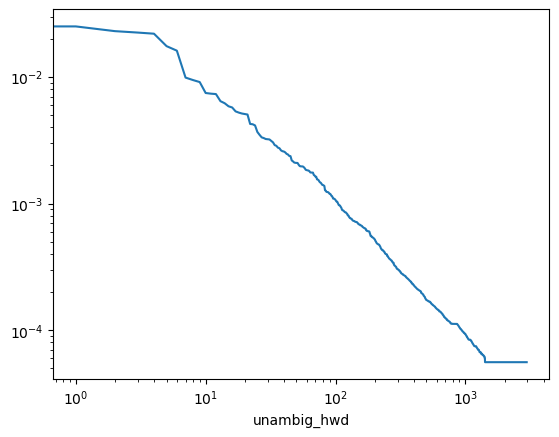

In [32]:
fl.pagerank.plot()
plt.xscale('log')
plt.yscale('log')

# The top

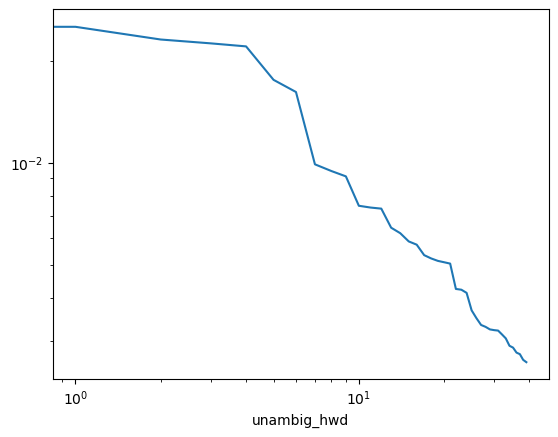

In [40]:
fl.iloc[:40].pagerank.plot()
plt.xscale('log')
plt.yscale('log')

In [91]:
fl.head(40)

,en,hu,la,pl,id,uro,pos,defi,comment,ambig,pagerank
unambig_hwd,,,,,,,,,,,
exist,exist,van,exsto,byc1,2587,u,V,real,NaN,False,0.025244
at,at,-na1l,apud,u,2744,u,G,=pat[place/1026],NaN,False,0.025138
reason,reason,ok,ratio,powo1d,1892,u,N,cause =poss,relational noun,False,0.023064
cause,cause,ok,causa,powo1d,1891,NaN,N,reason,NaN,False,0.022473
real,real,igazi,verus,prawdziwy,1126,u,A,exist,NaN,False,0.022016
place/1026,place,hely,locus,miejsce,1026,u,N,"point, ' at/2744",NaN,True,0.017554
in,in,-ban,in,w,2758,u,G,"=rel contain, at/2744 =rel",NaN,False,0.016165
quantity,quantity,mennyise1g,quantitas,ilos1c1,1667,NaN,N,"much, <large>",NaN,False,0.009905
degree,degree,fok,gradus,stopien1,836,u,N,"step, process has",scale HAS % Longman: qualification,False,0.009466


## _Exist_ and _real_

### Out-neighbors

In [83]:
list(def_graph.neighbors('exist'))

['real']

In [84]:
list(def_graph.neighbors('real'))

['exist']

### In-neighbors

In [87]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('exist'))))
%pprint

Pretty printing has been turned OFF
['actual', 'destroy', 'establish', 'fact', 'live', 'make', 'new', 'origin', 'real', 'thing']
Pretty printing has been turned ON


In [88]:
%pprint
print(sorted(list(def_graph.reverse().neighbors('real'))))
%pprint

Pretty printing has been turned OFF
['article', 'artificial', 'believe', 'dream', 'exist', 'expect', 'fiction', 'imaginary', 'practice', 'prove', 'romantic', 'sincere', 'succeed/2718', 'success']
Pretty printing has been turned ON


# The tail

In [43]:
fl[fl.pagerank<.000057]

,en,hu,la,pl,id,uro,pos,defi,comment,ambig,pagerank
unambig_hwd,,,,,,,,,,,
stretch,stretch,nyu1jt,porrigo,rozcia1gac1,1823,NaN,N,"cause[=pat[long,extend]]",NaN,False,0.000056
when,when,mikor,quando,kiedy,1689,u,D,at/2744 what(time),NaN,False,0.000056
presence,presence,jelenle1t,praesentia,obecnos1c1,1185,NaN,N,=poss at/2744 place/1026,NaN,False,0.000056
sorry,sorry,bu1s,tristis,smutny,342,u,A,feel pity,NaN,False,0.000056
something,something,valami,aliquid,cos1,2579,NaN,N,thing,NaN,False,0.000056
...,...,...,...,...,...,...,...,...,...,...,...
friend,friend,bara1t,amicus,przyjaciel,228,u,N,"person, =poss know, =poss like/3382, =poss trust",NaN,False,0.000056
fresh,fresh,friss,viridis,s1wiez1y,863,NaN,N,"new, replace",NaN,False,0.000056
french-canadian,french-canadian,francia-kanadai,#,#,3299,NaN,A,"member [nation,@canada], has parent, parent me...",NaN,False,0.000056


In [68]:
fl.groupby([in_degree_ser==0,fl.pagerank<5.578344e-05]).size()

       pagerank
False  False       1414
True   True        1551
dtype: int64